Conduct initial data exploration and data preparation, perform at least one Association Rule analysis on 
the datasets and provide detailed interpretation of the findings

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
import io
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
df.head()
# Dataset is now stored in a Pandas Dataframe


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.isnull().sum()
#see have any null values in the data frame

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#want to make sure order product have qty

df = df.loc[df['Quantity'] > 0]
df.shape

(531285, 8)

In [ ]:
#dropping 133361 customer without ID from product quantity zero as it maybe one time off buying

EDA_df = df.dropna(subset=['CustomerID'])
EDA_df.shape

(397924, 8)

In [ ]:
EDA_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# removing the spaces in the description ( decrease will time tabulate)
EDA_df['Description'] = EDA_df['Description'].str.strip() 

In [ ]:
# invoice to become string
EDA_df['InvoiceNo'] = EDA_df['InvoiceNo'].astype('str')  

In [ ]:
#remove null values in invoice columns
EDA_df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

In [ ]:
#Remove credit term invoices
EDA_df = EDA_df[EDA_df['InvoiceNo'].str.contains('C')]        

Consolidate the items into rows

In [ ]:
# CustomerID, StockCode, Quantity to include so can create a pivot table

customer_item_matrix = EDA_df.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum')

In [ ]:
customer_item_matrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,15039,16008,16010,16011,16012,16014,16015,16016,16033,16043,16045,16046,16048,16049,16052,16054,16216,16218,16219,16225,16235,16236,16237,16238,16254,16259,17001,17003,17021,17038,...,90209B,90209C,90210A,90210B,90210C,90210D,90211A,90211B,90212B,90212C,90214A,90214B,90214C,90214D,90214E,90214F,90214G,90214H,90214I,90214J,90214K,90214L,90214M,90214N,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
customer_item_matrix.shape

(4339, 3665)

In [ ]:
EDA_df['CustomerID'].nunique()

4339

In [ ]:
EDA_df['StockCode'].nunique()

3665

In [ ]:
 # looking at the total items purchased by CustomerID 12350.0
customer_item_matrix.loc[12350.0].sum()  

197.0

Replacing NaN with 0 and other values as 1 using One Hot Encoding and lambda function.

reference: https://www.w3schools.com/python/python_lambda.asp

In [ ]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x>0 else 0)

customer_item_matrix.head(10)

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,15039,16008,16010,16011,16012,16014,16015,16016,16033,16043,16045,16046,16048,16049,16052,16054,16216,16218,16219,16225,16235,16236,16237,16238,16254,16259,17001,17003,17021,17038,...,90209B,90209C,90210A,90210B,90210C,90210D,90211A,90211B,90212B,90212C,90214A,90214B,90214C,90214D,90214E,90214F,90214G,90214H,90214I,90214J,90214K,90214L,90214M,90214N,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
12353.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12354.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12355.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
 # removing Postage cost as it is irrelevant
customer_item_matrix.drop('POST', inplace=True, axis=1)

In [ ]:
#checking whether the postage is remove
customer_item_matrix.shape   

(4339, 3664)

Apriori is a popular algorithm [1] for extracting frequent itemsets with applications in association rule learning. The apriori algorithm has been designed to operate on databases containing transactions, such as purchases by customers of a store. An itemset is considered as "frequent" if it meets a user-specified support threshold. For instance, if the support threshold is set to 0.5 (50%), a frequent itemset is defined as a set of items that occur together in at least 50% of all transactions in the database.

In [ ]:
frequent_itemsets = apriori(customer_item_matrix, min_support=0.07, use_colnames=True)

frequent_itemsets.shape

(130, 2)

In [ ]:
frequent_itemsets.head()

,support,itemsets
0,0.075824,(20685)
1,0.077207,(20724)
2,0.122609,(20725)
3,0.085734,(20726)
4,0.105554,(20727)



Generate the rules with their corresponding support, confidence and lift:

In [ ]:
# setting the threshold of Lift Value as 1.
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1) 
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(20728),(20725),0.110394,0.122609,0.070984,0.643006,5.244369,0.057449,2.457721
1,(20725),(20728),0.122609,0.110394,0.070984,0.578947,5.244369,0.057449,2.112814
2,(85123A),(21733),0.197280,0.088730,0.071906,0.364486,4.107804,0.054401,1.433910
3,(21733),(85123A),0.088730,0.197280,0.071906,0.810390,4.107804,0.054401,4.233521
4,(22086),(22910),0.141277,0.108320,0.075363,0.533442,4.924692,0.060060,1.911188


Visualizing Relationship between Support
Using the upport (X axis)and Confidence(y axis) 

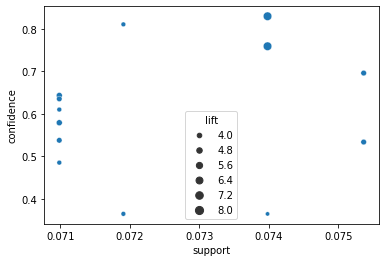

In [ ]:
# plot scatter 
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

The output to look for a large lift (6.4) and high confidence (.8).

In [ ]:
rules[ (rules['lift'] >= 6.4) &
       (rules['confidence'] >= 0.8) ]   # confidence >= 80%

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(22697),(22699),0.089191,0.097488,0.07398,0.829457,8.508311,0.065285,5.292003


Interpretation of index 10:

The purchase rate of items Stock ID 22697 and Stock ID 22699 together is 0.073.

82.9% of the customers who buy StockID 22697 also buy StockID 22699.

When 22697 is bought, the purchase rate of buying 22699 increases by 8.5 times.